<h1> Классификация спама в e-mail сообщениях

<h2> Постановка задачи:</h2>
<p>Дан датасет - сообщения и пометка, является ли это сообщение спамом (957 сообщений на тренировочной выборке и 125 на тестовой). Цель задачи - научиться автоматически помечать сообщения со спамом.</p>

<h3> Читаем тренировочные данные

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np          
import seaborn as sns         
import sklearn
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')


train_dataset = []
test_dataset = []
dataset = []

train_dataset = pd.read_csv("archive/SMS_train.csv", sep=',', encoding="Windows-1252")
test_dataset = pd.read_csv("archive/SMS_test.csv", sep=',', encoding="Windows-1252")

dataset = pd.concat((train_dataset, test_dataset), ignore_index=True)
#dataset = train_dataset

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mievs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mievs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h3> Взглянем на информацию о датасете

In [85]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
dataset.shape

(1082, 3)

In [87]:
dataset.head(10)

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam
5,6,REMINDER FROM O2: To get 2.50 pounds free call...,Spam
6,7,Huh y lei...,Non-Spam
7,8,Why don't you wait 'til at least wednesday to ...,Non-Spam
8,9,Ard 6 like dat lor.,Non-Spam
9,10,Ok lor... Sony ericsson salesman... I ask shuh...,Non-Spam


In [88]:
dataset.tail(10)

,S. No.,Message_body,Label
1072,116,I'm awake oh. What's up.,Non-Spam
1073,117,Think + da. You wil do.,Non-Spam
1074,118,PISS IS TALKING IS SOMEONE THAT REALISE U THAT...,Non-Spam
1075,119,I am in hospital da. . I will return home in e...,Non-Spam
1076,120,Gettin rdy to ship comp,Non-Spam
1077,121,7 wonders in My WORLD 7th You 6th Ur style 5th...,Non-Spam
1078,122,Try to do something dear. You read something f...,Non-Spam
1079,123,Sun ah... Thk mayb can if dun have anythin on....,Non-Spam
1080,124,"SYMPTOMS when U are in love: ""1.U like listeni...",Non-Spam
1081,125,Great. Have a safe trip. Dont panic surrender ...,Non-Spam


In [89]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        1082 non-null   int64 
 1   Message_body  1082 non-null   object
 2   Label         1082 non-null   object
dtypes: int64(1), object(2)
memory usage: 25.5+ KB


<h3> Получаем набор всех слов встречающихся в выборке (Составляем "Мешок слов")

In [90]:
tokens = []


for xl in dataset["Message_body"]:
    token = nltk.word_tokenize(str(xl).lower())
    token = [t for t in token if len(t) > 2]
    for t in token:
        tokens.append(t)
tokens = set(tokens)
tokens = list(tokens)

In [91]:
def gram_tokens(tokens, gram = 2):
    if gram > 1:
        t = []
        for i in range(len(tokens) - gram + 1): 
            t += [" ".join(tokens[i:i + gram])]
        return t

def process_tokens(tokens, stem = True, stop_words = True):
    if stop_words:
        sw = stopwords.words("english")
        tokens = [token for token in tokens if token not in sw]
    if stem:
        stemmer = nltk.PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [92]:
#tokens = gram_tokens(tokens, 2)
tokens = process_tokens(tokens, True, True)

In [93]:
#количество неповторяющихся слов
tokens.__len__()

3428

<h3> Обрабатываем датасет. Теперь для каждой записи указано сколько раз встречается то или иное слово в сообщении

In [94]:
from collections import Counter

def bag_of_words(tokens, dataset):
    df = pd.DataFrame(dataset)
    for index, row in dataset.iterrows():
        msg_tokens = nltk.word_tokenize(str(row["Message_body"]).lower())
        msg_tokens = [t for t in msg_tokens if len(t) > 2]
        #msg_tokens = gram_tokens(msg_tokens, 2)
        msg_tokens = process_tokens(msg_tokens, True, True)
        count_letter = Counter(msg_tokens)
        for token in tokens:
            df.loc[index, token] = count_letter[token]
    return df.copy()

df = bag_of_words(tokens, dataset)


df.drop("Message_body", axis=1, inplace=True)

In [95]:
df.drop("S. No.", axis=1, inplace=True)

<h3> Вот так теперь выглядит датасет

In [96]:
df.head(10)

,Label,goodmorn,randi,barrel,happi,anyon,angri,zebra,anim,mathemat,...,max,holla,afternoon,when/wher,hppnss,bare,phonebook,'ll,east,juici
0,Non-Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Non-Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Non-Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Non-Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Non-Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Non-Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Non-Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Non-Spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Columns: 3042 entries, Label to juici
dtypes: float64(3041), object(1)
memory usage: 25.1+ MB


In [98]:
df.iloc[:,0] = df.iloc[:,0].astype('category')

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Columns: 3042 entries, Label to juici
dtypes: category(1), float64(3041)
memory usage: 25.1 MB


<h3> Сводная таблица по количественным признакам встречающихся слов

In [100]:
df.describe()

,goodmorn,randi,barrel,happi,anyon,angri,zebra,anim,mathemat,20/f,...,max,holla,afternoon,when/wher,hppnss,bare,phonebook,'ll,east,juici
count,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,...,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000
mean,0.000924,0.000924,0.000924,0.015712,0.002773,0.003697,0.000924,0.000924,0.000924,0.000924,...,0.000924,0.001848,0.003697,0.000924,0.000924,0.001848,0.000924,0.033272,0.000924,0.001848
std,0.030401,0.030401,0.030401,0.145016,0.052607,0.060717,0.030401,0.030401,0.030401,0.030401,...,0.030401,0.042973,0.060717,0.030401,0.030401,0.042973,0.030401,0.189459,0.030401,0.042973
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000


<h3> Сводная таблица по категориям сообщений

In [101]:
df.describe(include = ['category'])

,Label
count,1082
unique,2
top,Non-Spam
freq,884


<h3> Строим корреляционную матрицу

In [102]:
corr_matrix = df.corr()
corr_matrix

,goodmorn,randi,barrel,happi,anyon,angri,zebra,anim,mathemat,20/f,...,max,holla,afternoon,when/wher,hppnss,bare,phonebook,'ll,east,juici
goodmorn,1.000000,-0.000925,-0.000925,-0.003297,-0.001604,-0.001853,-0.000925,-0.000925,-0.000925,-0.000925,...,-0.000925,-0.001309,-0.001853,-0.000925,-0.000925,-0.001309,-0.000925,-0.005344,-0.000925,-0.001309
randi,-0.000925,1.000000,-0.000925,-0.003297,-0.001604,-0.001853,-0.000925,-0.000925,-0.000925,-0.000925,...,-0.000925,-0.001309,-0.001853,-0.000925,-0.000925,-0.001309,-0.000925,-0.005344,-0.000925,-0.001309
barrel,-0.000925,-0.000925,1.000000,-0.003297,-0.001604,-0.001853,-0.000925,-0.000925,-0.000925,-0.000925,...,-0.000925,-0.001309,-0.001853,-0.000925,-0.000925,-0.001309,-0.000925,-0.005344,-0.000925,-0.001309
happi,-0.003297,-0.003297,-0.003297,1.000000,-0.005716,-0.006603,-0.003297,-0.003297,-0.003297,-0.003297,...,-0.003297,-0.004665,-0.006603,-0.003297,-0.003297,-0.004665,-0.003297,0.014626,-0.003297,-0.004665
anyon,-0.001604,-0.001604,-0.001604,-0.005716,1.000000,-0.003212,-0.001604,-0.001604,-0.001604,-0.001604,...,-0.001604,-0.002269,-0.003212,-0.001604,-0.001604,-0.002269,-0.001604,0.083550,-0.001604,-0.002269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bare,-0.001309,-0.001309,-0.001309,-0.004665,-0.002269,-0.002621,-0.001309,-0.001309,-0.001309,-0.001309,...,-0.001309,-0.001852,-0.002621,-0.001309,-0.001309,1.000000,-0.001309,-0.007561,-0.001309,-0.001852
phonebook,-0.000925,-0.000925,-0.000925,-0.003297,-0.001604,-0.001853,-0.000925,-0.000925,-0.000925,-0.000925,...,-0.000925,-0.001309,-0.001853,-0.000925,-0.000925,-0.001309,1.000000,-0.005344,-0.000925,-0.001309
'll,-0.005344,-0.005344,-0.005344,0.014626,0.083550,-0.010702,-0.005344,-0.005344,-0.005344,-0.005344,...,-0.005344,-0.007561,-0.010702,-0.005344,-0.005344,-0.007561,-0.005344,1.000000,-0.005344,-0.007561
east,-0.000925,-0.000925,-0.000925,-0.003297,-0.001604,-0.001853,-0.000925,-0.000925,-0.000925,-0.000925,...,-0.000925,-0.001309,-0.001853,-0.000925,-0.000925,-0.001309,-0.000925,-0.005344,1.000000,-0.001309


<AxesSubplot:>

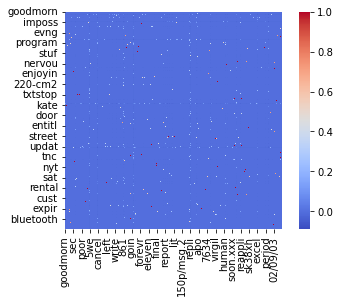

In [103]:
sns.heatmap(corr_matrix, square=True, cmap='coolwarm')

Визуализировав корреляционную матрицу мы видим связь между некоторыми словами.

<h3> Данные являются несбалансированными

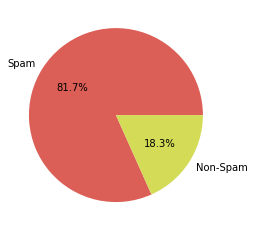

In [104]:
plt.pie(df.Label.value_counts(), labels = ["Spam", "Non-Spam"], colors = sns.color_palette("hls"), autopct = '%1.1f%%')
pass

<h3> Визуализируем какие слова чаще всего используются в сообщениях со спамом

Для поиска таких слов воспользуемся библиотекой WordCloud

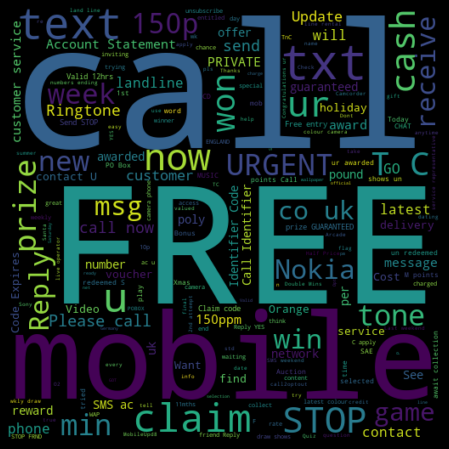

In [105]:
from wordcloud import WordCloud

text = " ".join(list(dataset[dataset["Label"] == "Spam"]["Message_body"]))

# Generate a word cloud image
wordcloud = WordCloud(width = 512,height = 512).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

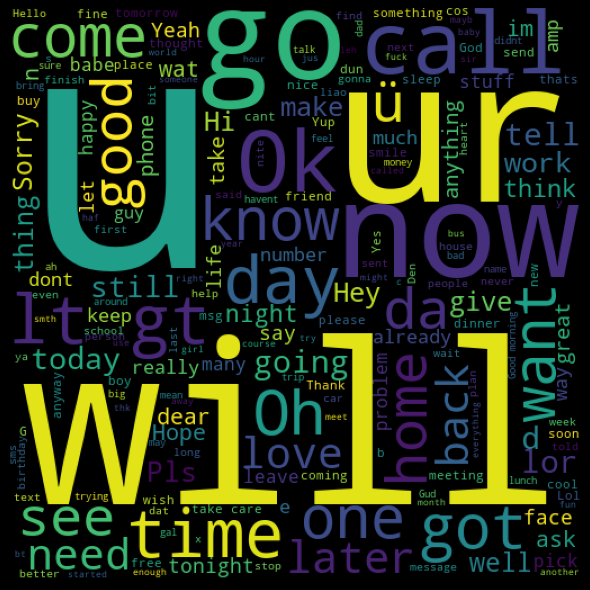

In [106]:
ham_words = ' '.join(list(dataset[dataset["Label"] == "Non-Spam"]["Message_body"]))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

<h3> Нормализуем данные

In [107]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'category']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'category']

In [108]:
for col_num in numerical_columns:
    if  not df[col_num].std(axis = 0):
        print(df[col_num])
        df.drop(col_num, axis=1, inplace=True)
        numerical_columns.remove(col_num)

In [109]:
data_numerical = df[numerical_columns]
data_numerical.describe()

,goodmorn,randi,barrel,happi,anyon,angri,zebra,anim,mathemat,20/f,...,max,holla,afternoon,when/wher,hppnss,bare,phonebook,'ll,east,juici
count,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,...,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000
mean,0.000924,0.000924,0.000924,0.015712,0.002773,0.003697,0.000924,0.000924,0.000924,0.000924,...,0.000924,0.001848,0.003697,0.000924,0.000924,0.001848,0.000924,0.033272,0.000924,0.001848
std,0.030401,0.030401,0.030401,0.145016,0.052607,0.060717,0.030401,0.030401,0.030401,0.030401,...,0.030401,0.042973,0.060717,0.030401,0.030401,0.042973,0.030401,0.189459,0.030401,0.042973
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000


In [110]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

,goodmorn,randi,barrel,happi,anyon,angri,zebra,anim,mathemat,20/f,...,max,holla,afternoon,when/wher,hppnss,bare,phonebook,'ll,east,juici
count,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,...,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03,1.082000e+03
mean,-7.511577e-17,-2.570020e-16,-2.169462e-16,1.105606e-17,6.216787e-17,-2.458113e-16,-1.314029e-17,-1.314029e-17,-1.019671e-16,1.173969e-16,...,-5.961485e-16,9.604147e-17,1.256568e-16,-1.902745e-17,8.051554e-17,1.776665e-16,-2.107769e-16,-3.989415e-16,-4.890509e-16,1.290429e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.040090e-02,-3.040090e-02,-3.040090e-02,-1.083445e-01,-5.270467e-02,-6.088633e-02,-3.040090e-02,-3.040090e-02,-3.040090e-02,-3.040090e-02,...,-3.040090e-02,-4.301326e-02,-6.088633e-02,-3.040090e-02,-3.040090e-02,-4.301326e-02,-3.040090e-02,-1.756143e-01,-3.040090e-02,-4.301326e-02
25%,-3.040090e-02,-3.040090e-02,-3.040090e-02,-1.083445e-01,-5.270467e-02,-6.088633e-02,-3.040090e-02,-3.040090e-02,-3.040090e-02,-3.040090e-02,...,-3.040090e-02,-4.301326e-02,-6.088633e-02,-3.040090e-02,-3.040090e-02,-4.301326e-02,-3.040090e-02,-1.756143e-01,-3.040090e-02,-4.301326e-02
50%,-3.040090e-02,-3.040090e-02,-3.040090e-02,-1.083445e-01,-5.270467e-02,-6.088633e-02,-3.040090e-02,-3.040090e-02,-3.040090e-02,-3.040090e-02,...,-3.040090e-02,-4.301326e-02,-6.088633e-02,-3.040090e-02,-3.040090e-02,-4.301326e-02,-3.040090e-02,-1.756143e-01,-3.040090e-02,-4.301326e-02
75%,-3.040090e-02,-3.040090e-02,-3.040090e-02,-1.083445e-01,-5.270467e-02,-6.088633e-02,-3.040090e-02,-3.040090e-02,-3.040090e-02,-3.040090e-02,...,-3.040090e-02,-4.301326e-02,-6.088633e-02,-3.040090e-02,-3.040090e-02,-4.301326e-02,-3.040090e-02,-1.756143e-01,-3.040090e-02,-4.301326e-02
max,3.286337e+01,3.286337e+01,3.286337e+01,1.368328e+01,1.895611e+01,1.640887e+01,3.286337e+01,3.286337e+01,3.286337e+01,3.286337e+01,...,3.286337e+01,2.322716e+01,1.640887e+01,3.286337e+01,3.286337e+01,2.322716e+01,3.286337e+01,1.038075e+01,3.286337e+01,2.322716e+01


In [111]:
data = pd.concat((data_numerical, df['Label']), axis = 1)

In [112]:
X = data.drop('Label', axis = 1)
y = data['Label']

<h3> Разбиваем данные на тренировочную и тестовую выборку

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 50)

In [114]:
X_train

,goodmorn,randi,barrel,happi,anyon,angri,zebra,anim,mathemat,20/f,...,max,holla,afternoon,when/wher,hppnss,bare,phonebook,'ll,east,juici
708,-0.030401,-0.030401,-0.030401,-0.108345,-0.052705,-0.060886,-0.030401,-0.030401,-0.030401,-0.030401,...,-0.030401,-0.043013,-0.060886,-0.030401,-0.030401,-0.043013,-0.030401,-0.175614,-0.030401,-0.043013
316,-0.030401,-0.030401,-0.030401,-0.108345,-0.052705,-0.060886,-0.030401,-0.030401,-0.030401,-0.030401,...,-0.030401,-0.043013,-0.060886,-0.030401,-0.030401,-0.043013,-0.030401,-0.175614,-0.030401,-0.043013
285,-0.030401,-0.030401,-0.030401,-0.108345,-0.052705,-0.060886,-0.030401,-0.030401,-0.030401,-0.030401,...,-0.030401,-0.043013,-0.060886,-0.030401,-0.030401,-0.043013,-0.030401,-0.175614,-0.030401,-0.043013
524,-0.030401,-0.030401,-0.030401,-0.108345,-0.052705,-0.060886,-0.030401,-0.030401,-0.030401,-0.030401,...,-0.030401,-0.043013,-0.060886,-0.030401,-0.030401,-0.043013,-0.030401,-0.175614,-0.030401,-0.043013
418,-0.030401,-0.030401,-0.030401,13.683279,-0.052705,-0.060886,-0.030401,-0.030401,-0.030401,-0.030401,...,-0.030401,-0.043013,-0.060886,-0.030401,-0.030401,-0.043013,-0.030401,-0.175614,-0.030401,-0.043013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,-0.030401,-0.030401,-0.030401,-0.108345,-0.052705,-0.060886,-0.030401,-0.030401,-0.030401,-0.030401,...,-0.030401,-0.043013,-0.060886,-0.030401,-0.030401,-0.043013,-0.030401,-0.175614,-0.030401,-0.043013
229,-0.030401,-0.030401,-0.030401,-0.108345,-0.052705,-0.060886,-0.030401,-0.030401,-0.030401,-0.030401,...,-0.030401,-0.043013,-0.060886,-0.030401,-0.030401,-0.043013,-0.030401,-0.175614,-0.030401,-0.043013
70,-0.030401,-0.030401,-0.030401,6.787467,-0.052705,-0.060886,-0.030401,-0.030401,-0.030401,-0.030401,...,-0.030401,-0.043013,-0.060886,-0.030401,-0.030401,-0.043013,-0.030401,-0.175614,-0.030401,-0.043013
132,-0.030401,-0.030401,-0.030401,-0.108345,-0.052705,-0.060886,-0.030401,-0.030401,-0.030401,-0.030401,...,-0.030401,-0.043013,-0.060886,-0.030401,-0.030401,-0.043013,-0.030401,-0.175614,-0.030401,-0.043013


In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import ensemble

<h3> Попробуем метод ближайших соседей с разным количеством соседей

In [116]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
print(knn)

err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

KNeighborsClassifier(n_neighbors=1)
Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.1834862385321101


In [117]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)
print(knn)

err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

KNeighborsClassifier(n_neighbors=2)
Ошибка на обучающей выборке:  0.14285714285714285
Ошибка на тестовой выборке:  0.23853211009174313


In [118]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
print(knn)

err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

KNeighborsClassifier(n_neighbors=3)
Ошибка на обучающей выборке:  0.14182939362795477
Ошибка на тестовой выборке:  0.23853211009174313


In [119]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
print(knn)

err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

KNeighborsClassifier()
Ошибка на обучающей выборке:  0.16032887975334018
Ошибка на тестовой выборке:  0.23853211009174313


In [120]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train, y_train)
print(knn)

err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

KNeighborsClassifier(n_neighbors=8)
Ошибка на обучающей выборке:  0.17677286742034942
Ошибка на тестовой выборке:  0.23853211009174313


In [121]:
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train, y_train)
print(knn)

err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

KNeighborsClassifier(n_neighbors=13)
Ошибка на обучающей выборке:  0.17677286742034942
Ошибка на тестовой выборке:  0.23853211009174313


In [122]:
knn = KNeighborsClassifier(n_neighbors = 21)
knn.fit(X_train, y_train)
print(knn)

err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

KNeighborsClassifier(n_neighbors=21)
Ошибка на обучающей выборке:  0.17677286742034942
Ошибка на тестовой выборке:  0.23853211009174313


In [123]:
knn = KNeighborsClassifier(n_neighbors = 34)
knn.fit(X_train, y_train)
print(knn)

err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

KNeighborsClassifier(n_neighbors=34)
Ошибка на обучающей выборке:  0.17677286742034942
Ошибка на тестовой выборке:  0.23853211009174313


<h3> Найдём оптимальное количество соседей

In [124]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid = {'n_neighbors': range(1, 100)}, cv = 5)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print('Кросс-валидационная ошибка: ', best_cv_err)
print('Оптимальное количество соседей: ', best_n_neighbors)

Кросс-валидационная ошибка:  0.1500237906423474
Оптимальное количество соседей:  1


<h3> Support Vector Machine

In [125]:
svc = SVC(gamma = 'auto')
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

Ошибка на обучающей выборке:  0.0041109969167523125
Ошибка на тестовой выборке:  0.1834862385321101


<h3> Random Forest

In [126]:
rf = ensemble.RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.08256880733944955


<h3> Extremely Randomized Trees

In [127]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 100).fit(X_train, y_train)

err_train = np.mean(y_train != ert.predict(X_train))
err_test  = np.mean(y_test  != ert.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.06422018348623854


<h3> AdaBoost

In [128]:
ada = ensemble.AdaBoostClassifier(n_estimators = 100)
ada.fit(X_train, y_train)

err_train = np.mean(y_train != ada.predict(X_train))
err_test = np.mean(y_test != ada.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.06422018348623854


<h3> GBT

In [129]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 100)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test = np.mean(y_test != gbt.predict(X_test))

print('Ошибка на обучающей выборке: ', err_train)
print('Ошибка на тестовой выборке: ', err_test)

Ошибка на обучающей выборке:  0.014388489208633094
Ошибка на тестовой выборке:  0.06422018348623854


<h1> Выводы

<h3> По данным </h3>
<ui>
<li> Данные являются <b>несбалансированными</b> (81.7 / 18.3)
<li> Большинство сообщений является спамом
<li> Чаще всего в спаме встречаются слова: <code>free</code>, <code>call</code>, <code>mobile</code>, <code>text</code>, <code>claim</code>
</ui>

<h3> По результатам работы алгоритмов </h3>
<ui>
<li>Алгоритм kNN оптимальное количество соседей составило 1 с ошибкой на обучающей выборке ~ 0% и с ошибкой на тестовой выборке - 18.3%
<li>Алгоритм Support Vector Machine: ошибка на обучающей выборке - 0.4%, ошибка на тестовой выборке ~ 18.3%
<li>Алгоритм Random Forest: ошибка на обучающей выборке - 0%, ошибка на тестовой выборке ~ 9.17%
<li>Алгоритм Extremely Randomized Trees: ошибка на обучающей выборке - 0%, ошибка на тестовой выборке ~ 7.3%
<li>Алгоритм AdaBoost: ошибка на обучающей выборке - 0%, ошибка на тестовой выборке ~ 6.4%
<li>Алгоритм GBT: ошибка на обучающей выборке - 1.5%, ошибка на тестовой выборке ~ 6.4%
<li>Лучше всего на тестовой выборке себя показали алгоритмы AdaBoost и GBT с ошибкой в 6.4%, однако при использовании алгоритма GBT на обучающей выборке ошибка 1.5% в то время как у алгоритма AdaBoost она равна 0%
<ui>